# Fashion-MNIST Classification with an MDA Head
This notebook trains a small convolutional encoder with a mixture discriminant analysis (MDA) head 
on Fashion-MNIST, then evaluates calibration plots.


### Setup


In [1]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from dnll import MDAHead, EM_DNLLLoss


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device =', device)


device = cuda


### Data


In [3]:
tfm = transforms.ToTensor()
train_ds = datasets.FashionMNIST(root='./data', train=True, transform=tfm, download=True)
test_ds  = datasets.FashionMNIST(root='./data', train=False, transform=tfm, download=True)
train_ld = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=2, pin_memory=True)
test_ld  = DataLoader(test_ds,  batch_size=1024, shuffle=False, num_workers=2, pin_memory=True)
len(train_ds), len(test_ds)


(60000, 10000)

### Model: encoder + MDA head


In [4]:
class Encoder(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
        )
        self.proj = nn.Linear(256, dim)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.proj(x)

class DeepMDA(nn.Module):
    def __init__(self, C, D, K):
        super().__init__()
        self.encoder = Encoder(D)
        self.head = MDAHead(C, D, K)

    def forward(self, x):
        z = self.encoder(x)
        return self.head(z)


### Train & Eval


In [5]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    ok = tot = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        ok += (logits.argmax(1) == y).sum().item()
        tot += y.size(0)
    return ok / tot


model = DeepMDA(C=10, D=9, K=10).to(device)
opt = torch.optim.Adam(model.parameters())
loss_fn = EM_DNLLLoss(lambda_reg=.1)

train_acc = []
test_acc = []

for epoch in range(1, 51):
    model.train()
    loss_sum = acc_sum = n_sum = 0
    for x, y in train_ld:
        x, y = x.to(device), y.to(device)
        z = model.encoder(x)
        loss = loss_fn(model.head, z, y)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        with torch.no_grad():
            logits = model.head(z)
            pred = logits.argmax(1)
            acc_sum += (pred == y).sum().item()
            n_sum += y.size(0)
            loss_sum += loss.item() * y.size(0)
    tr_acc = acc_sum / n_sum
    te_acc = evaluate(model, test_ld)
    train_acc.append(tr_acc)
    test_acc.append(te_acc)
    print(f'[MDA {epoch:02d}] train loss={loss_sum/n_sum:.4f} acc={tr_acc:.4f} | test acc={te_acc:.4f}')


[MDA 01] train loss=6.4985 acc=0.8049 | test acc=0.8396
[MDA 02] train loss=4.5996 acc=0.8830 | test acc=0.8840
[MDA 03] train loss=2.7838 acc=0.9030 | test acc=0.9050
[MDA 04] train loss=0.6275 acc=0.9186 | test acc=0.8884
[MDA 05] train loss=-0.2951 acc=0.9314 | test acc=0.9190
[MDA 06] train loss=-0.5765 acc=0.9487 | test acc=0.9118
[MDA 07] train loss=-0.6807 acc=0.9557 | test acc=0.9054
[MDA 08] train loss=-0.7373 acc=0.9615 | test acc=0.9121
[MDA 09] train loss=-0.7726 acc=0.9675 | test acc=0.9233
[MDA 10] train loss=-0.7896 acc=0.9741 | test acc=0.8976
[MDA 11] train loss=-0.7976 acc=0.9781 | test acc=0.9291
[MDA 12] train loss=-0.8053 acc=0.9805 | test acc=0.9102
[MDA 13] train loss=-0.8146 acc=0.9844 | test acc=0.9037
[MDA 14] train loss=-0.8172 acc=0.9870 | test acc=0.9276
[MDA 15] train loss=-0.8208 acc=0.9896 | test acc=0.9200
[MDA 16] train loss=-0.8154 acc=0.9908 | test acc=0.9133
[MDA 17] train loss=-0.8057 acc=0.9943 | test acc=0.8926
[MDA 18] train loss=-0.7953 acc=0.9

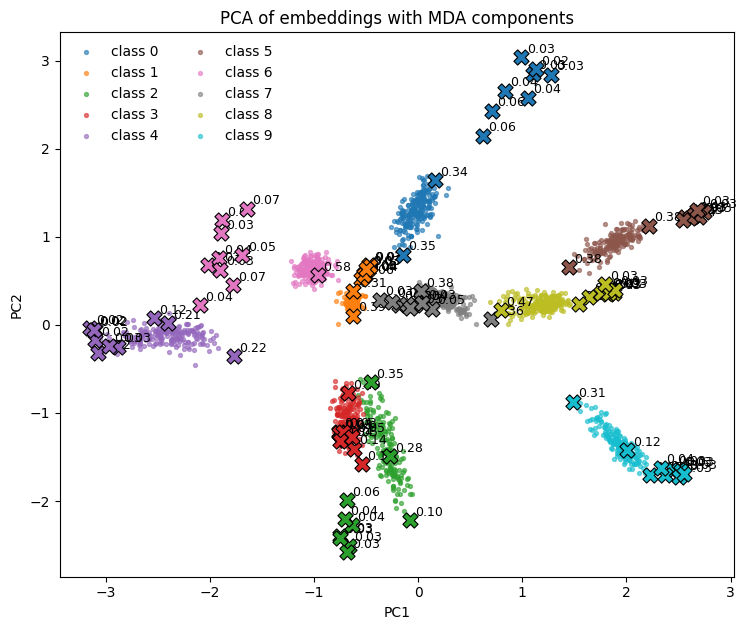

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# PCA of a sample of embeddings with component means
model.eval()
max_points = 2000
embeds = []
labels = []
with torch.no_grad():
    for x, y in train_ld:
        x, y = x.to(device), y.to(device)
        z = model.encoder(x)
        embeds.append(z.cpu())
        labels.append(y.cpu())
        if sum(t.size(0) for t in embeds) >= max_points:
            break

embeds = torch.cat(embeds, dim=0)[:max_points]
labels = torch.cat(labels, dim=0)[:max_points]

center = embeds.mean(dim=0, keepdim=True)
embeds_centered = embeds - center
U, S, V = torch.pca_lowrank(embeds_centered, q=2)
proj = embeds_centered @ V[:, :2]

mu = model.head.mu.detach().cpu()
mix_probs = torch.softmax(model.head.mixture_logits, dim=-1).detach().cpu()
C = model.head.C
K = model.head.K
mu_flat = mu.reshape(C * K, -1)
mu_proj = (mu_flat - center) @ V[:, :2]

plt.figure(figsize=(7.6, 6.4))
colors = plt.cm.tab10.colors
for c in range(C):
    idx = labels == c
    plt.scatter(proj[idx, 0], proj[idx, 1], s=8, color=colors[c % len(colors)],
                alpha=0.6, label=f"class {c}")

for c in range(C):
    for k in range(K):
        i = c * K + k
        w = mix_probs[c, k].item()
        plt.scatter(mu_proj[i, 0], mu_proj[i, 1], marker="X", s=120,
                    color=colors[c % len(colors)], edgecolors="black",
                    linewidths=0.8, zorder=5)
        plt.text(mu_proj[i, 0] + 0.05, mu_proj[i, 1] + 0.05, f"{w:.2f}",
                 fontsize=9, color="black")

plt.title("PCA of embeddings with MDA components")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(ncol=2, frameon=False)
plt.tight_layout()
plt.savefig('plots/fmnist.png', dpi=600)


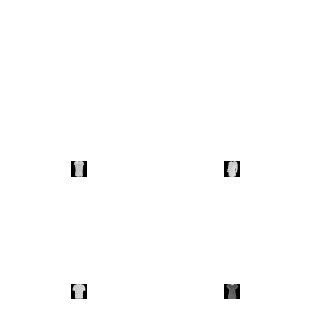

In [10]:
import matplotlib.pyplot as plt


# Show Bag examples for both mixture components
bag_idx = 0
n_per_comp = 2
bag_examples = {k: [] for k in range(model.head.K)}

with torch.no_grad():
    for x, y in train_ld:
        mask = y == bag_idx
        if not mask.any():
            continue
        xb = x[mask].to(device)
        z = model.encoder(xb)

        mu_b = model.head.mu[bag_idx].to(z.dtype)
        log_cov_b = model.head.log_cov[bag_idx].to(z.dtype)
        log_mix_b = torch.log_softmax(model.head.mixture_logits[bag_idx], dim=-1)

        diff = z.unsqueeze(1) - mu_b.unsqueeze(0)
        m2 = (diff * diff).sum(-1)
        var = torch.exp(log_cov_b)
        log_det = model.head.D * log_cov_b
        log_comp = -0.5 * (m2 / var.unsqueeze(0) + log_det.unsqueeze(0))
        log_r = log_mix_b.unsqueeze(0) + log_comp
        comp = log_r.argmax(dim=-1)

        for k in range(model.head.K):
            if len(bag_examples[k]) >= n_per_comp:
                continue
            k_idx = (comp == k).nonzero(as_tuple=False).squeeze(1)
            for j in k_idx:
                if len(bag_examples[k]) >= n_per_comp:
                    break
                bag_examples[k].append(xb[j].cpu())

        if all(len(bag_examples[k]) >= n_per_comp for k in range(model.head.K)):
            break

fig, axes = plt.subplots(model.head.K, n_per_comp, figsize=(1.6 * n_per_comp, 3.2))
if model.head.K == 1:
    axes = [axes]
for k in range(model.head.K):
    for j in range(n_per_comp):
        ax = axes[k][j] if model.head.K > 1 else axes[j]
        ax.axis("off")
        if j < len(bag_examples[k]):
            ax.imshow(bag_examples[k][j].squeeze(0), cmap="gray")
    if model.head.K > 1:
        axes[k][0].set_ylabel(f"Bag comp {k}", rotation=0, labelpad=30, va="center")
plt.tight_layout()
plt.show()


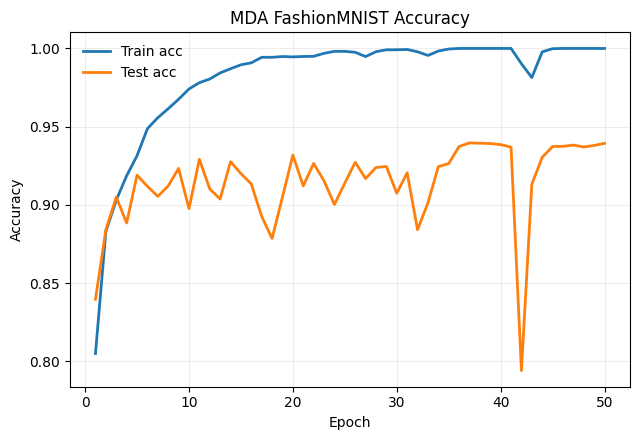

In [8]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_acc) + 1)
plt.figure(figsize=(6.5, 4.5))
plt.plot(epochs, train_acc, label='Train acc', linewidth=2)
plt.plot(epochs, test_acc, label='Test acc', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('MDA FashionMNIST Accuracy')
plt.legend(frameon=False)
plt.grid(True, linewidth=0.4, alpha=0.4)
plt.tight_layout()
plt.show()
